In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import technical_analysis.backtest_kz as bt
from data_pipelines.data_manipulation import DataManipulation
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = 'ignore', category = pd.errors.PerformanceWarning)
%matplotlib inline

SYMBOL = 'BTC-USD'
scale = 1
range_list = [5,6,7,8,10,12,14,15,20]
range_list = [i*scale for i in range_list]
period = 'max'
interval = '1wk'
start_date = ''
end_data = ''
source = 'yahoo'

data = DataManipulation(SYMBOL, source, range_list, period=period, interval=interval, scale=scale, prefix_path='..', saved_to_csv=True)

[*********************100%***********************]  1 of 1 completed
Start TA-LIB module
created indicators columns with TA-LIB


In [2]:
df = data.df.copy()
df.tail()

,ad,adj_close,adx_10,adx_12,adx_14,adx_15,adx_20,adx_5,adx_6,adx_7,...,wma_12,wma_14,wma_15,wma_20,wma_5,wma_6,wma_7,wma_8,daily_return,feature_label
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-10-24,4143739040190.8921,20635.6035,27.6145,28.9407,28.4171,27.8085,23.8048,16.9558,16.9287,20.1585,...,19821.5234,20024.6254,20125.9725,20407.6641,19812.4859,19711.9345,19647.6238,19669.0435,0.0546,1.0000
2022-10-31,4219259670191.5112,20926.4863,25.2069,27.3840,27.4031,26.9878,23.5110,20.5888,18.1455,19.4222,...,19920.3536,20053.6629,20137.3580,20424.2415,20257.2322,20130.7718,20015.5725,19931.8155,0.0141,1.0000
2022-11-07,3865589259577.2017,16353.3652,26.1611,27.8896,27.7555,27.3062,23.7659,25.8699,22.1577,22.2270,...,19359.1248,19495.9073,19591.1257,20003.5064,19052.1128,19141.8416,19186.4201,19201.7486,-0.2185,1.0000
2022-11-14,3912613011635.9736,16687.5176,27.0198,28.3531,28.0827,27.6034,24.0080,30.0948,25.5012,24.6312,...,18915.7239,19047.6817,19144.8585,19636.8521,18164.5815,18376.5141,18528.2606,18631.1085,0.0204,0.0000
2022-11-18,3900636840763.1235,16768.5234,27.7926,28.7779,28.3865,27.8807,24.2380,33.4748,28.2875,26.6919,...,18522.3406,18682.9408,18762.7869,19290.3391,17476.0906,17765.7078,17974.5165,18137.2079,0.0049,1.0000


In [3]:
ext_df = data.extract_features()

In [4]:
ext_df.tail()

,st_stoch,st_ich,st_cut_ema5_sma10,st_macd,st_ich_close,st_dmi,st_cut_sma10_close,st_hisse,st_mfi,st_fishert,...,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,daily_return,feature_label
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-10-24,1,0,1,1,0,0,0,0,0.6667,0.6667,...,1,0,1,1,0,0,1,1,0.0546,1.0000
2022-10-31,0,0,1,1,0,0,0,0,0.6667,0.6667,...,1,1,0,1,1,0,0,1,0.0141,1.0000
2022-11-07,0,0,0,1,0,0,1,0,0.6667,0.6667,...,1,1,1,0,1,1,0,0,-0.2185,1.0000
2022-11-14,0,0,0,1,0,0,1,0,0.6667,0.6667,...,0,1,1,1,0,1,1,0,0.0204,0.0000
2022-11-18,1,0,0,1,0,0,1,0,0.6667,0.6667,...,1,0,1,1,1,0,1,1,0.0049,1.0000


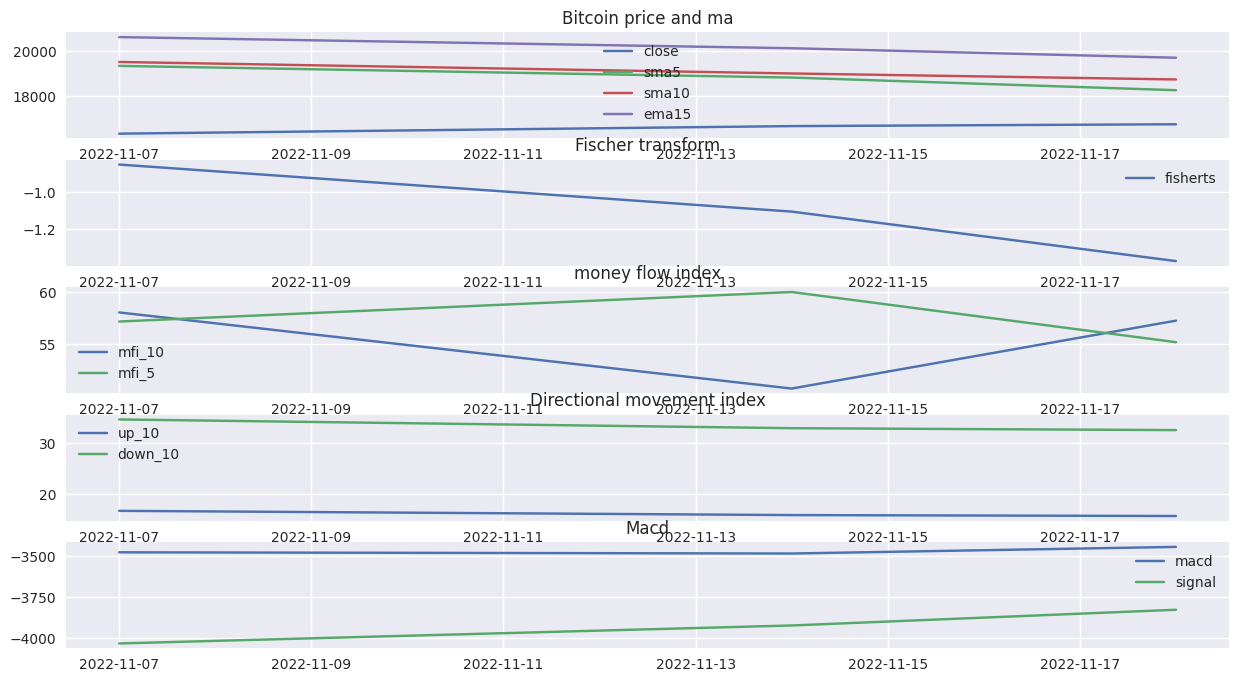

In [5]:
bt.bt_plot_indicators(df['2022-11-01':], 'Bitcoin')

In [6]:
st_fishert_bt = bt.bt_threshold(df, 'fishert', 1, -5)

In [ ]:
bt.bt_plot_ind(df, st_fishert_bt, 'fishert')

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [9]:
X = ext_df.copy()
X.reset_index(inplace=True)
X.drop(columns=['Datetime', 'feature_label'], axis=1, inplace=True)
Y = ext_df.feature_label.copy()

In [10]:
Y = Y.reset_index()

In [11]:
Y.drop(columns=['Datetime'], axis=1, inplace=True)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=46)

In [13]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [14]:
pred = model.predict(X_test)
type(pred)

numpy.ndarray

In [15]:
pred = pred > 0.5

In [16]:
pred = pred.astype(int)

In [17]:
accuracy_score(pred, y_test)

1.0

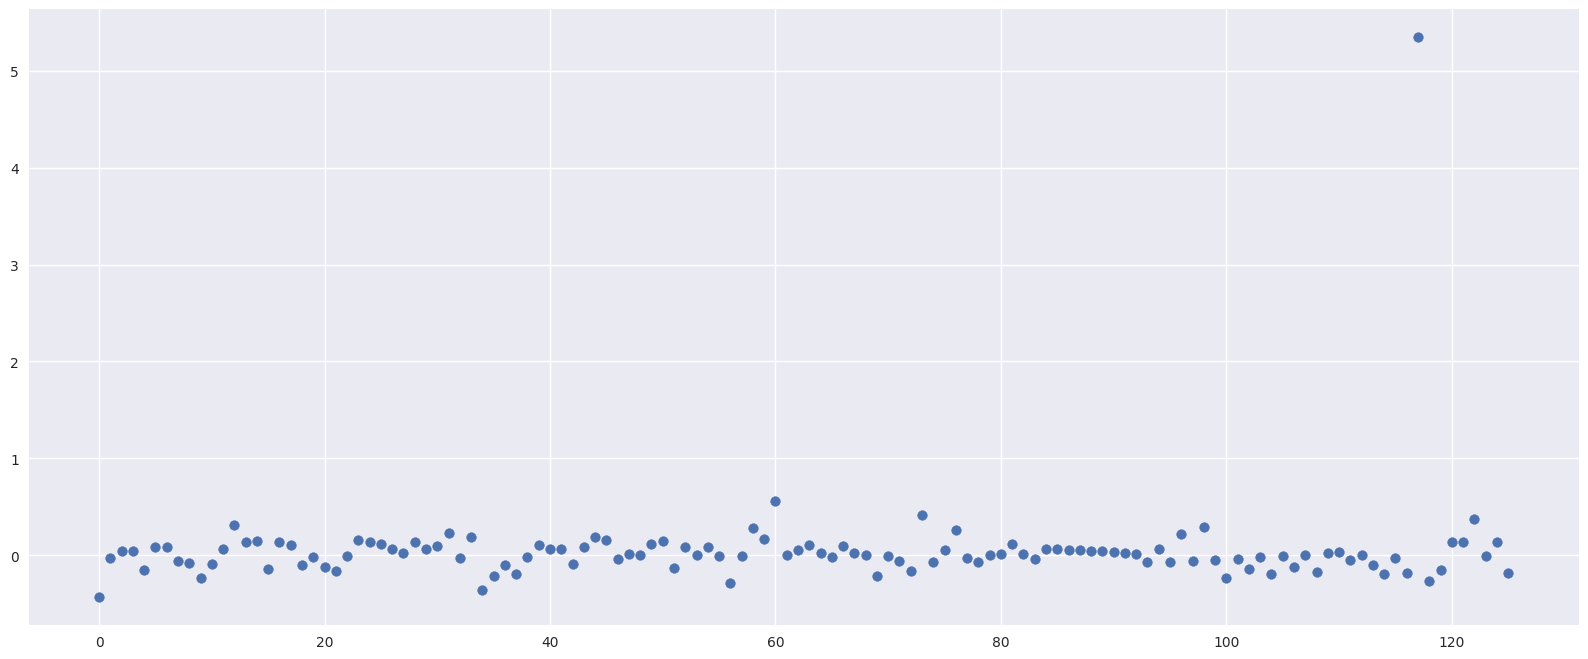

In [18]:
import matplotlib.pyplot as plt
import numpy as np
weigths = model.coef_
fig, ax = plt.subplots(1,1, figsize=(20,8))
plt.scatter(np.arange(0,len(np.column_stack(weigths).ravel())), np.column_stack(weigths).ravel())

In [19]:
np.column_stack(weigths).ravel().size

126

In [20]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

In [21]:
X_train.shape

(250, 126)

In [22]:
model = Sequential(
    [               
        tf.keras.Input(shape=(126,)),
        Dense(units=128, activation='sigmoid'),
        Dense(units=64, activation='sigmoid'),
        Dense(units=32, activation='sigmoid'),
        Dense(units=16, activation='sigmoid'),
        Dense(units=1, activation='sigmoid')
    ], name = "my_model" 
)   

2022-11-18 15:36:42.515715: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-18 15:36:42.541837: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-18 15:36:42.541893: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-18 15:36:42.542849: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [23]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               16256     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 27,137
Trainable params: 27,137
Non-trainable params: 0
_________________________________________________________________


In [24]:
[layer1, layer2, layer3, *a] = model.layers

In [25]:
W1,b1 = layer1.get_weights()
W2,b2 = layer2.get_weights()
W3,b3 = layer3.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (126, 128), b1 shape = (128,)
W2 shape = (128, 64), b2 shape = (64,)
W3 shape = (64, 32), b3 shape = (32,)


In [26]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.001),
)

model.fit(
    X_train, y_train,
    epochs=40
)

Epoch 1/40
8/8 [==============================] - 1s 4ms/step - loss: 0.6926
Epoch 2/40
8/8 [==============================] - 0s 4ms/step - loss: 0.6827
Epoch 3/40
8/8 [==============================] - 0s 4ms/step - loss: 0.6795
Epoch 4/40
8/8 [==============================] - 0s 4ms/step - loss: 0.6776
Epoch 5/40
8/8 [==============================] - 0s 4ms/step - loss: 0.6724
Epoch 6/40
8/8 [==============================] - 0s 4ms/step - loss: 0.6679
Epoch 7/40
8/8 [==============================] - 0s 4ms/step - loss: 0.6608
Epoch 8/40
8/8 [==============================] - 0s 4ms/step - loss: 0.6526
Epoch 9/40
8/8 [==============================] - 0s 4ms/step - loss: 0.6436
Epoch 10/40
8/8 [==============================] - 0s 6ms/step - loss: 0.6312
Epoch 11/40
8/8 [==============================] - 0s 5ms/step - loss: 0.6190
Epoch 12/40
8/8 [==============================] - 0s 4ms/step - loss: 0.6085
Epoch 13/40
8/8 [==============================] - 0s 4ms/step - loss: 0.

In [27]:
pred = model.predict(X_test)

2/2 [==============================] - 0s 3ms/step


In [28]:
pred = (pred >= 0.5).astype(int)

In [29]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
1/1 [==============================] - 0s 92ms/step - loss: 0.1079
test loss, test acc: 0.10785635560750961


In [30]:
print(confusion_matrix(y_test, pred))

[[30  0]
 [ 1 32]]


In [31]:
accuracy_score(y_test, pred)

0.9841269841269841

In [32]:
pd.DataFrame(pred).value_counts()

1    32
0    31
dtype: int64

In [33]:
ext_df['kz_score'] = ext_df.sum(axis = 1)

<AxesSubplot:xlabel='Datetime'>

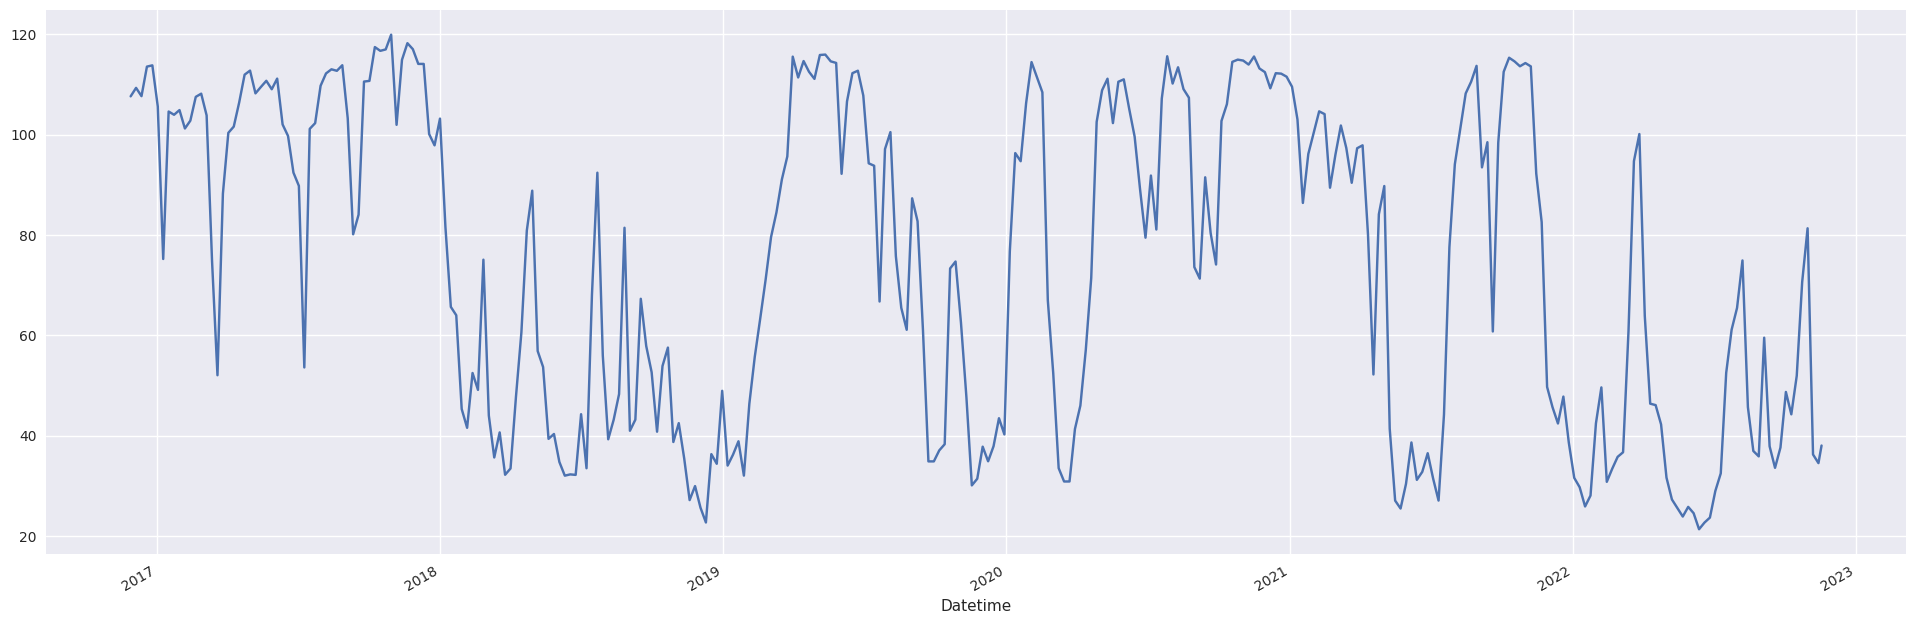

In [34]:
ext_df.kz_score.plot(figsize=(24,8))

In [35]:
ext_df.shape, df.shape

((313, 128), (314, 220))

In [36]:
df.index, ext_df.index

(DatetimeIndex(['2016-11-21', '2016-11-28', '2016-12-05', '2016-12-12',
                '2016-12-19', '2016-12-26', '2017-01-02', '2017-01-09',
                '2017-01-16', '2017-01-23',
                ...
                '2022-09-19', '2022-09-26', '2022-10-03', '2022-10-10',
                '2022-10-17', '2022-10-24', '2022-10-31', '2022-11-07',
                '2022-11-14', '2022-11-18'],
               dtype='datetime64[ns]', name='Datetime', length=314, freq=None),
 DatetimeIndex(['2016-11-28', '2016-12-05', '2016-12-12', '2016-12-19',
                '2016-12-26', '2017-01-02', '2017-01-09', '2017-01-16',
                '2017-01-23', '2017-01-30',
                ...
                '2022-09-19', '2022-09-26', '2022-10-03', '2022-10-10',
                '2022-10-17', '2022-10-24', '2022-10-31', '2022-11-07',
                '2022-11-14', '2022-11-18'],
               dtype='datetime64[ns]', name='Datetime', length=313, freq=None))

<AxesSubplot:>

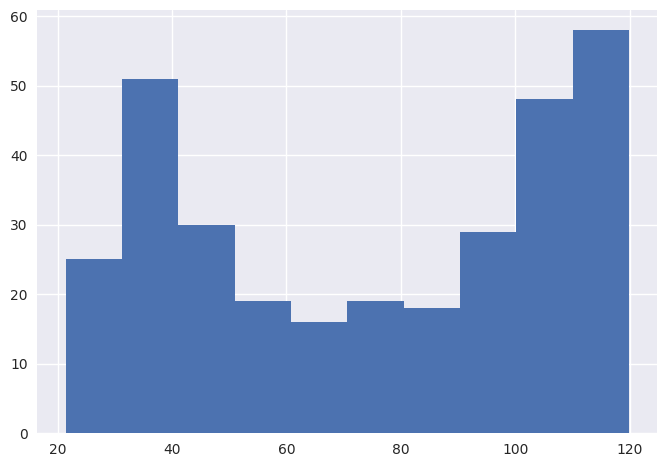

In [37]:
ext_df.kz_score.hist()

Text(0.5, 1.0, 'KZ Index')

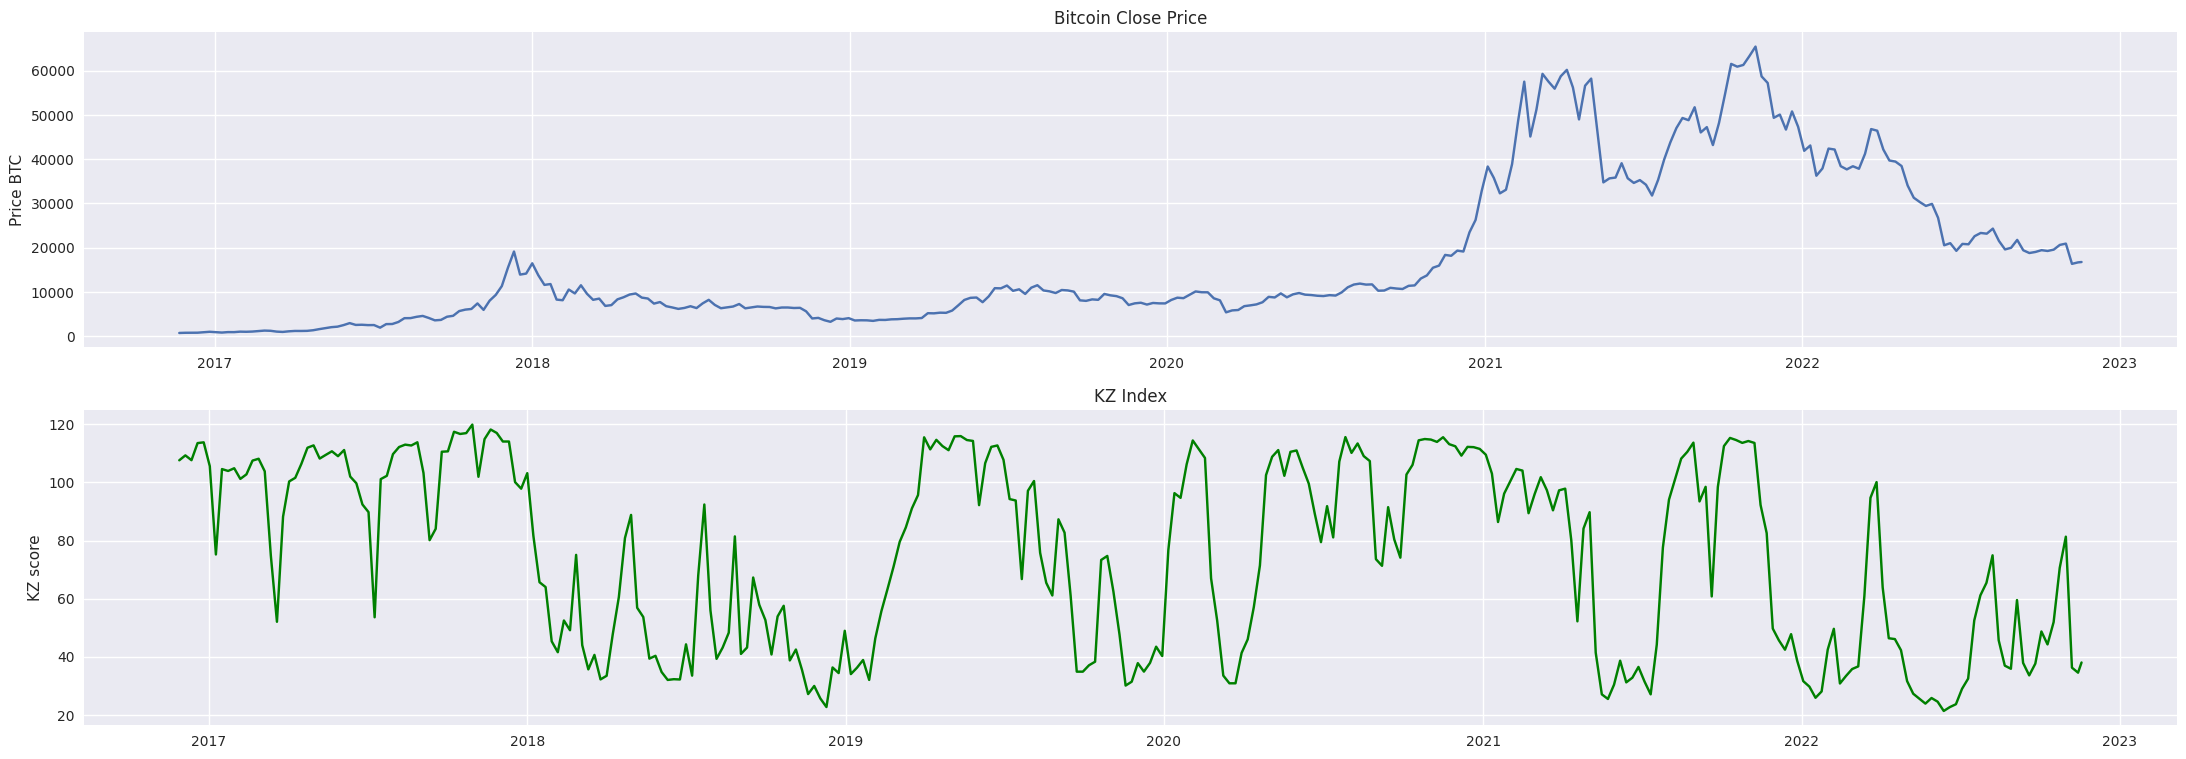

In [38]:
kz = ext_df.kz_score
close = df.close

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(27,9))
ax1.plot(close)
ax1.set_ylabel('Price BTC')
ax1.set_title('Bitcoin Close Price')

ax2.plot(kz, color='green')
ax2.set_ylabel('KZ score')
ax2.set_title('KZ Index')

In [39]:
df.drop(['2016-11-21', '2022-11-14'], inplace=True)

In [40]:
df['kz_score'] = ext_df.kz_score

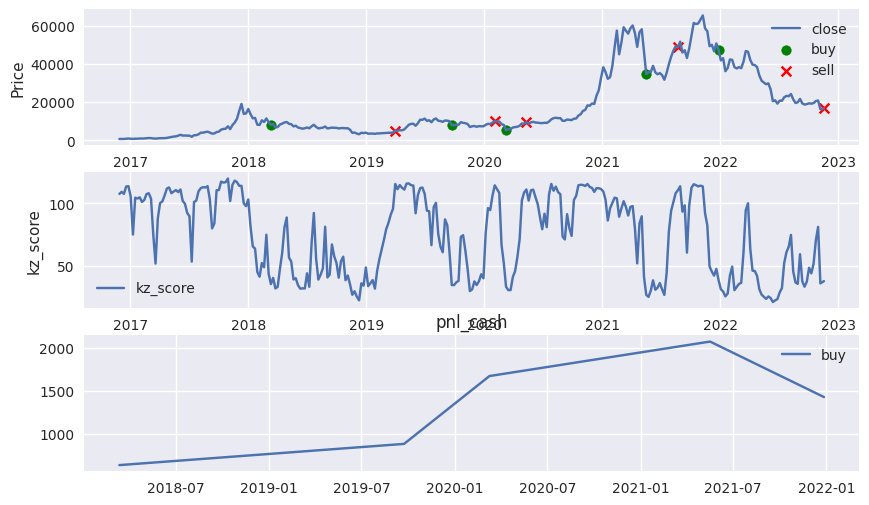

In [41]:
st_kz_score = bt.bt_threshold(df, 'kz_score', 110, 40)
bt.bt_plot_ind(df, st_kz_score, 'kz_score')

In [42]:
st_kz_score

,entry_time,exit_time,entry_price,exit_price,pnl_percent,pnl_cash
0,2018-03-12,2019-04-01,8223.6797,5198.8970,-0.3678,631.1862
1,2019-09-23,2020-02-03,8104.1855,10116.6738,0.2483,878.8821
2,2020-03-09,2020-05-11,5392.3149,9670.7393,0.7934,1671.4332
3,2021-05-17,2021-08-23,34770.5820,48829.8320,0.4043,2074.1050
4,2021-12-27,2022-11-18,47345.2188,16768.5234,-0.6458,1426.2065
